# The Graphical OWL Estimator for Precision Matrix Estimation

In [33]:
import numpy as np
from src.models.gowl import GOWLModel

from src.data.make_synthetic_data import generate_theta_star_gowl, standardize
from src.visualization.visualize import plot_multiple_theta_matrices_2d
from sklearn.covariance import GraphicalLasso

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


We define the Graphical Order Weighted $\ell_1$ (GOWL) estimator to be the solution to the following constrained optimization problem:

$$\min_{\Theta \succ 0} - \log \text{det } \Theta + \text{tr}(S \Theta) + \Omega_{\text{OWL}} (\Theta)$$

where 

$$\Omega_{\text{OWL}} (\Theta) = \lambda^T |\text{vechs}(\Theta)|_{\downarrow} = \sum_{i=1}^K \lambda_i |\text{vechs}(\Theta)|_{[i]}$$

Here $\Theta \in \mathbb{R}^{p \times p}$, $\text{vechs}(\Theta)_{[i]}$ is the $i^{th}$ largest off-diagonal component in magnitude of $\Theta$, $K = (p^2 - p)/2$, and $\lambda_1 \ge \lambda_2 \ge \cdots \ge \lambda_p \ge 0$. The goal of this estimator is to identify correlated groups within the precision matrix estimator $\hat{\Theta}$.

# Algorithm
We use a proximal method referred to as G-ISTA in the literature to compute our estimate. The algorithm is defined below:

# Simple Example

We design our first example for a very low $p$ and specify one group of size two. As is custom in the literature we also standardize our design matrix $X$.

In [37]:
p = 10
n = 100
n_blocks = 1
theta_star_eps, blocks, theta_star = generate_theta_star_gowl(p=p,
                                                              alpha=0.5,
                                                              noise=0.1,
                                                              n_blocks=n_blocks,
                                                              block_min_size=2,
                                                              block_max_size=6)

Hyperparameters should be chosen by cross-validation, but for this example we will choose $\lambda_1 = 0.001$ and $\lambda_2 = 0.01$. Now that we have generated $\theta^*$ and $\theta^* + \varepsilon$ we can generate a dataset by drawing i.i.d. from $N(0, (\theta^* + \varepsilon)^{-1}$ distribution.

In [38]:
theta_star_eps = theta_star_eps[0]  # by default we generate 1 trial, but for simulations we generate many trials
sigma = np.linalg.inv(theta_star_eps)
n = 100
X = np.random.multivariate_normal(np.zeros(p), sigma, n)
X = standardize(X)  # Standardize data to have mean zero and unit variance.
S = np.cov(X.T)

lam1 = 0.001  # controls sparsity
lam2 = 0.01  # encourages equality of coefficients

Now that we have generated the dataset, we can apply the GOWL model using G-ISTA with backtracking line search enabled and duality gap stopping criteria.

In [39]:
model = GOWLModel(X, S, lam1, lam2, 'backtracking', max_iters=100000)
model.fit()
theta_gowl = model.theta_hat

iterations: 17
Duality Gap: -0.0014329319481607428 < 1e-05. Exiting.


Let's compare the GOWL theta estimate to the Graphical LASSO model.

In [40]:
gl = GraphicalLasso()
gl.fit(S)
theta_glasso = gl.get_precision()

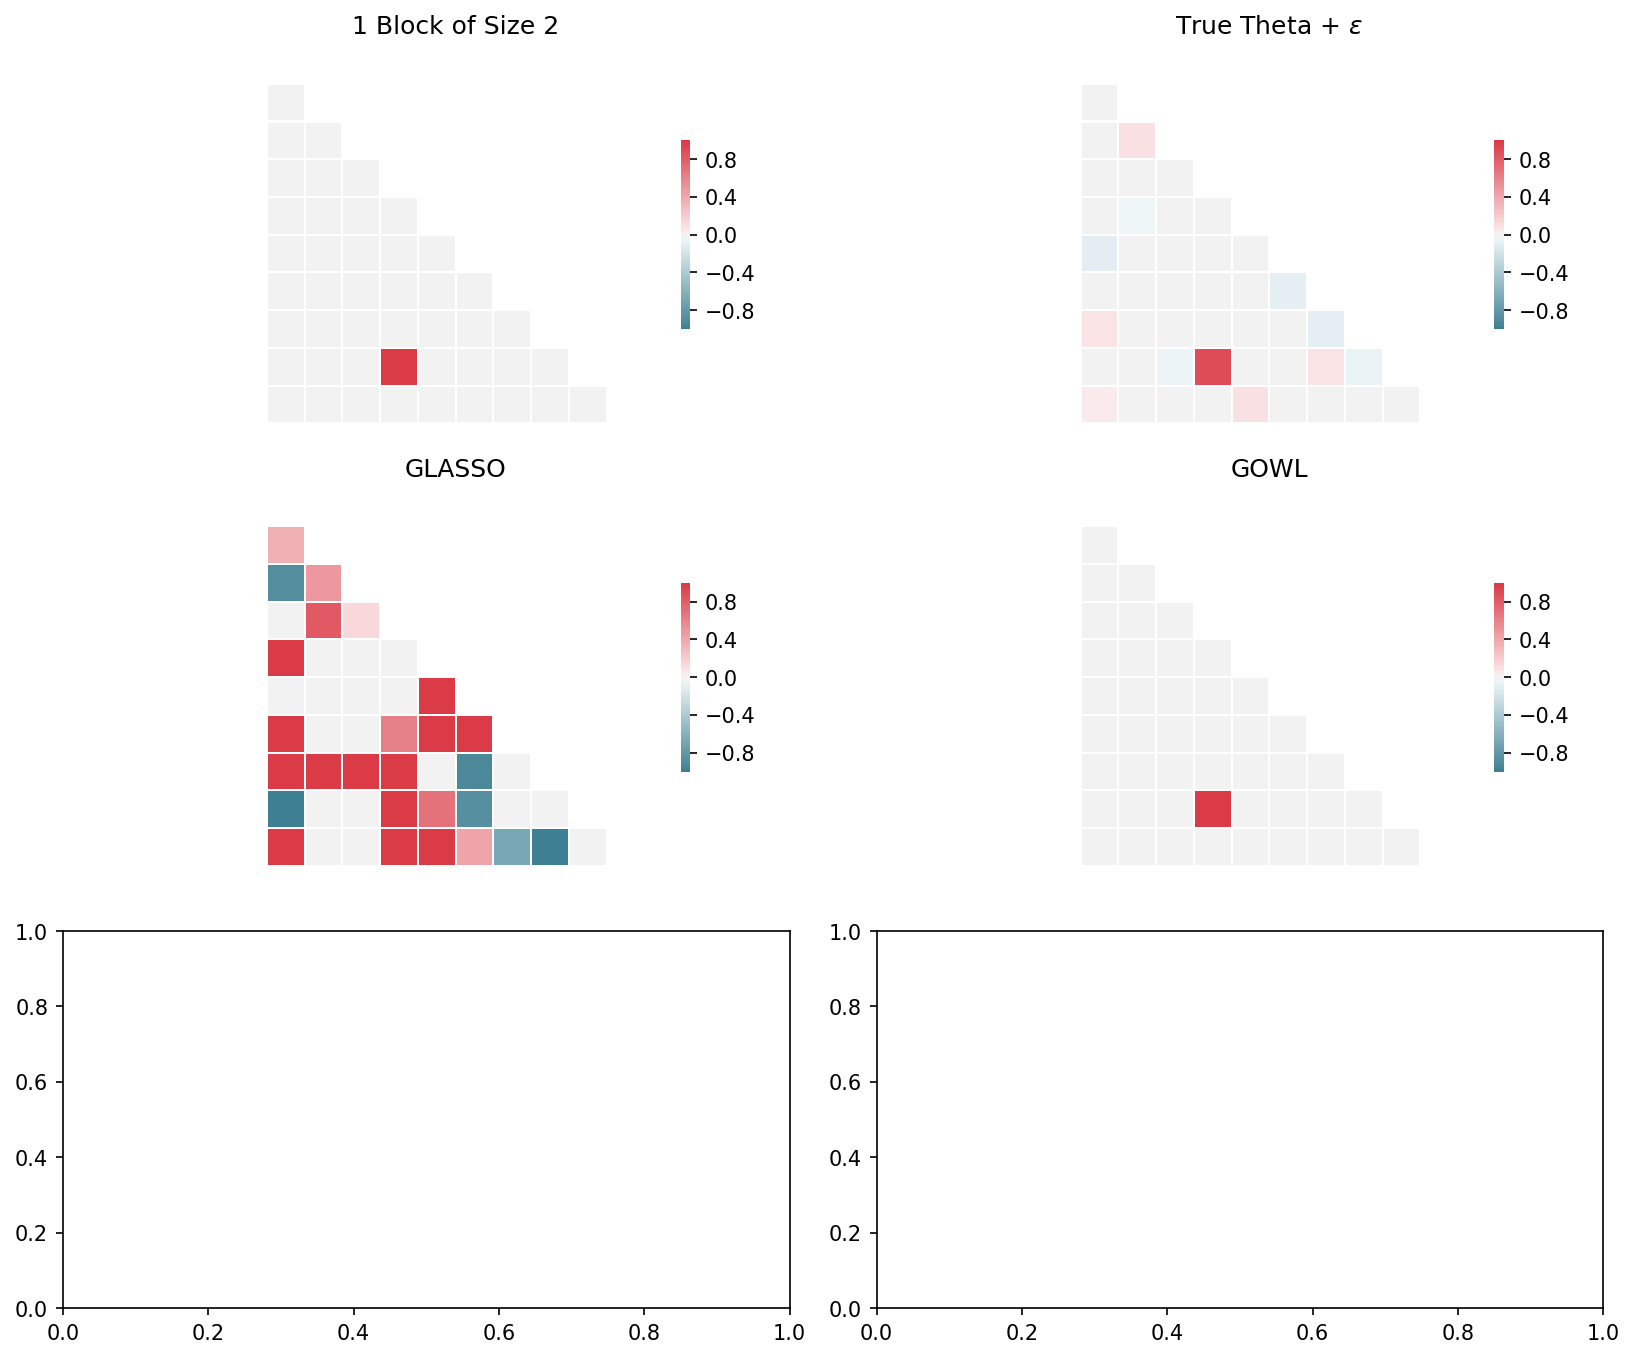

In [45]:
plot_multiple_theta_matrices_2d([
    theta_star, theta_star_eps, theta_glasso, theta_gowl
], [
    f"1 Block of Size 2", 'True Theta + $\epsilon$', 'GLASSO', 'GOWL'
])

In [24]:
theta_star[0].shape

(10, 10)